In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic

In [2]:
gpitch.amtgp.init_settings()
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

In [3]:
np.random.seed(0)
Nc = 3  # number of partials
var = np.random.rand(Nc)  # variances
leng = 10*np.random.rand(Nc)  # lengthscales
freq = 2000*np.random.rand()*np.asarray(range(1, Nc+ 1))  # frequencies
kern_com = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=leng, variances=var, frequencies=freq)
kern_act = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.005, variance=10.)

In [4]:
kern_com

Name,values,prior,constraint
unnamed.frequency_1,[ 875.17442253],None,+ve
unnamed.frequency_2,[ 1750.34884505],None,+ve
unnamed.frequency_3,[ 2625.52326758],None,+ve
unnamed.lengthscale_1,[ 5.44883183],None,+ve
unnamed.lengthscale_2,[ 4.23654799],None,+ve
unnamed.lengthscale_3,[ 6.45894113],None,+ve
unnamed.variance_1,[ 0.5488135],None,+ve
unnamed.variance_2,[ 0.71518937],None,+ve
unnamed.variance_3,[ 0.60276338],None,+ve


In [5]:
kern_act

Name,values,prior,constraint
unnamed.lengthscales,[ 0.005],None,+ve
unnamed.variance,[ 10.],None,+ve


In [6]:
N, fs = 400, 16e3
x = np.linspace(0., (N-1.)/fs, N).reshape(-1, 1)
Kcom = kern_com.compute_K_symm(x)
Kact = kern_act.compute_K_symm(x)

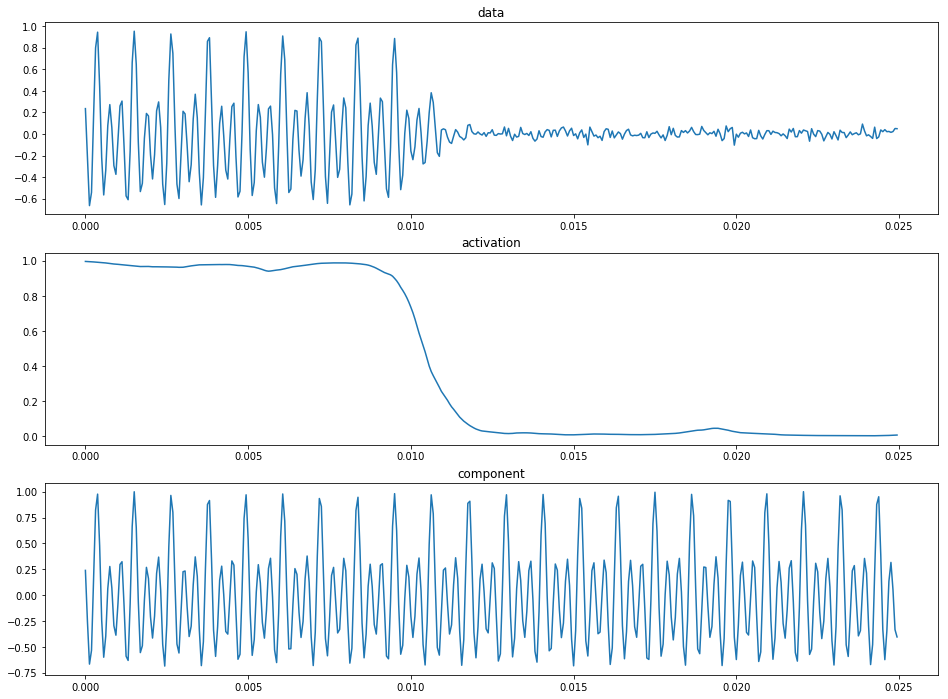

In [7]:
noise_var = 1e-3
com = np.random.multivariate_normal(np.zeros((N)), Kcom, 1).reshape(-1, 1)
com /= np.max(np.abs(com))
g = np.random.multivariate_normal(np.zeros((N)), Kact, 1).reshape(-1, 1)
act = logistic(g)
y = act*com + np.sqrt(noise_var)*np.random.randn(N,1)

plt.figure(figsize=(16, 12))
plt.subplot(3,1,1), plt.title('data')
plt.plot(x, y)
plt.subplot(3,1,2), plt.title('activation')
plt.plot(x, act)
plt.subplot(3,1,3), plt.title('component')
plt.plot(x, com)

In [8]:
ws, dec = N//1, 10  # samples per window, decimation factor
m = gpitch.modpdet.ModPDet(x=x, y=y, kern_com=kern_com, kern_act=kern_act, ws=ws, dec=dec, whiten=True)
m.model.kern1.fixed = True
m.model.kern2.fixed = False
m.model.likelihood.noise_var.fixed = False

In [9]:
maxiter, restarts = 500, 10
init_hyper, learnt_hyper, mse = m.optimize_restart(maxiter=maxiter, restarts=restarts)

| len: 0.03426704, 0.00911312 | sig: 14.97789867, 15.37674483 | noise_var: 0.01315760, 0.00123062 |
| len: 0.74034720, 0.00987839 | sig: 12.31522793, 13.84006344 | noise_var: 0.03730545, 0.00123318 |
| len: 0.19685205, 0.00808145 | sig: 1.48139830, 9.02200123 | noise_var: 0.07486060, 0.00124362 |
| len: 0.45265353, 0.00882333 | sig: 10.70576639, 12.23005295 | noise_var: 0.09154076, 0.00124317 |
| len: 0.14658374, 0.00947039 | sig: 13.78756501, 14.80354642 | noise_var: 0.04116265, 0.00125148 |
| len: 0.30526701, 0.00956708 | sig: 14.14593391, 15.06288243 | noise_var: 0.09906517, 0.00124392 |
| len: 0.19889222, 0.00845065 | sig: 9.85257520, 11.28734981 | noise_var: 0.01064953, 0.00123528 |
| len: 0.65091400, 0.00990855 | sig: 12.40969842, 14.22655776 | noise_var: 0.06844985, 0.00123443 |
| len: 0.41733314, 0.00833778 | sig: 5.74599539, 9.75420677 | noise_var: 0.03931224, 0.00123689 |
| len: 0.58971182, 0.01112153 | sig: 13.22350905, 14.73925009 | noise_var: 0.09290662, 0.00125232 |


In [10]:
m.model.kern2.lengthscales = learnt_hyper[0].mean().copy()
m.model.kern2.variance = learnt_hyper[1].mean().copy()
m.model.likelihood.noise_var = learnt_hyper[2].mean().copy()

In [11]:
m.model.kern2

Name,values,prior,constraint
kern2.lengthscales,[ 0.00927523],None,+ve
kern2.variance,[ 13.03426557],None,+ve


In [12]:
m.model.kern1

Name,values,prior,constraint
kern1.frequency_1,[ 875.17442253],None,[FIXED]
kern1.frequency_2,[ 1750.34884505],None,[FIXED]
kern1.frequency_3,[ 2625.52326758],None,[FIXED]
kern1.lengthscale_1,[ 5.44883183],None,[FIXED]
kern1.lengthscale_2,[ 4.23654799],None,[FIXED]
kern1.lengthscale_3,[ 6.45894113],None,[FIXED]
kern1.variance_1,[ 0.5488135],None,[FIXED]
kern1.variance_2,[ 0.71518937],None,[FIXED]
kern1.variance_3,[ 0.60276338],None,[FIXED]


In [13]:
print m.model.likelihood.noise_var

noise_var transform:[0.0, 0.1] prior:None
[ 0.00124049]


In [14]:
m.optimize_windowed(disp=1, maxiter=1000)

In [15]:
m.model.kern1

Name,values,prior,constraint
kern1.frequency_1,[ 875.17442253],None,[FIXED]
kern1.frequency_2,[ 1750.34884505],None,[FIXED]
kern1.frequency_3,[ 2625.52326758],None,[FIXED]
kern1.lengthscale_1,[ 5.44883183],None,[FIXED]
kern1.lengthscale_2,[ 4.23654799],None,[FIXED]
kern1.lengthscale_3,[ 6.45894113],None,[FIXED]
kern1.variance_1,[ 0.5488135],None,[FIXED]
kern1.variance_2,[ 0.71518937],None,[FIXED]
kern1.variance_3,[ 0.60276338],None,[FIXED]


In [16]:
m.model.kern2

Name,values,prior,constraint
kern2.lengthscales,[ 0.00743184],None,+ve
kern2.variance,[ 14.2826686],None,+ve


In [17]:
print m.model.likelihood.noise_var

noise_var transform:[0.0, 0.1] prior:None
[ 0.0012291]


In [18]:
mean_f, var_f = m.model.predict_f(x)
mean_g, var_g = m.model.predict_g(x)
mean_act = logistic(mean_g)

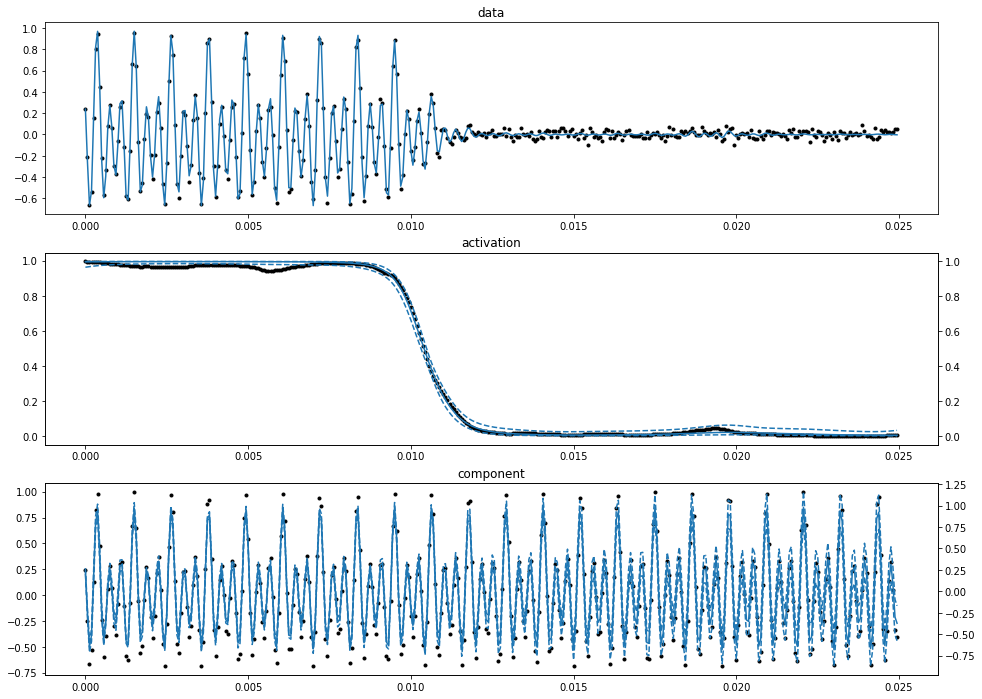

In [19]:
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plt.plot(x, y, '.k'), plt.title('data')
plt.plot(x, act*com)

plt.subplot(3,1,2)
plt.plot(x, act, '.k'), plt.title('activation')
plt.twinx()
plt.plot(x, mean_act)
plt.plot(x, logistic(mean_g + 2.*np.sqrt(var_g)), '--C0')
plt.plot(x, logistic(mean_g - 2.*np.sqrt(var_g)), '--C0')

plt.subplot(3,1,3)
plt.plot(x, com, '.k'), plt.title('component')
plt.twinx()
plt.plot(x, mean_f)
plt.plot(x, mean_f + 2.*np.sqrt(var_f), '--C0')
plt.plot(x, mean_f - 2.*np.sqrt(var_f), '--C0')